In [42]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [43]:
print(tf.__version__)

2.15.0


In [44]:
## import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Here we predict Exited feature, which means whether the customer leave (exit) the bank or not.

In [46]:
## Divide the Data into X and y
X = data.iloc[:,3:13] # remove the RowNumber, CustomerId, Surname
y = data.iloc[:,13]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [47]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [48]:
## Feature engineering - handle the categorical features
geography = pd.get_dummies(X["Geography"],drop_first=True)
## since there are 3 categories, we only need two dummy vars
## if the geography is France the Germany and Spain will be 0
geography.head()

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1


In [49]:
gender = pd.get_dummies(X["Gender"],drop_first=True)
gender.head()

,Male
0,0
1,0
2,0
3,0
4,0


In [50]:
X = X.drop(["Gender", "Geography"],axis=1)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,42,2,0.00,1,1,1,101348.88
1,608,41,1,83807.86,1,0,1,112542.58
2,502,42,8,159660.80,3,1,0,113931.57
3,699,39,1,0.00,2,0,0,93826.63
4,850,43,2,125510.82,1,1,1,79084.10


In [51]:
X = pd.concat([X, geography, gender], axis=1)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [52]:
## Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [53]:
## Feature Scaling
from sklearn.preprocessing import StandardScaler ## for ANN, minmax Scalar for CNN
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 0.16958176, -0.46460796,  0.00666099, ..., -0.5698444 ,
         1.74309049, -1.09168714],
       [-2.30455945,  0.30102557, -1.37744033, ...,  1.75486502,
        -0.57369368,  0.91601335],
       [-1.19119591, -0.94312892, -1.031415  , ..., -0.5698444 ,
        -0.57369368, -1.09168714],
       ...,
       [ 0.9015152 , -0.36890377,  0.00666099, ..., -0.5698444 ,
        -0.57369368,  0.91601335],
       [-0.62420521, -0.08179119,  1.39076231, ..., -0.5698444 ,
         1.74309049, -1.09168714],
       [-0.28401079,  0.87525072, -1.37744033, ...,  1.75486502,
        -0.57369368, -1.09168714]])

In [54]:
X_train.shape

(8000, 11)

In [67]:
## Initialize ANN
classifier = tf.keras.models.Sequential()
## Add the input layer (11 inputs)
classifier.add(tf.keras.layers.Dense(units=11,activation="relu")) ## activation is for the next layer
classifier.add(tf.keras.layers.Dropout(0.3)) ## Add the dropout layers
## Add the first hidden layer
classifier.add(tf.keras.layers.Dense(units=7,activation="relu"))
## Add the second hidden layer
classifier.add(tf.keras.layers.Dense(units=6,activation="relu"))
## Add the output layer
classifier.add(tf.keras.layers.Dense(units=1,activation="sigmoid")) ## binary classification

In [56]:
classifier.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.Accuracy()])
## adam is best optimizer, binary_crossentropy for binary classification

In [57]:
## Early stopping - when accuracy is not increasing we stop the model training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [58]:
model_history = classifier.fit(X_train, y_train, validation_split=0.1, batch_size=10, epochs=1000, callbacks=early_stopping)

Epoch 1/1000
720/720 [==============================] - 53s 3ms/step - loss: 0.4715 - accuracy: 0.0000e+00 - val_loss: 0.4311 - val_accuracy: 0.0000e+00
Epoch 2/1000
720/720 [==============================] - 2s 3ms/step - loss: 0.4331 - accuracy: 0.0000e+00 - val_loss: 0.4124 - val_accuracy: 0.0000e+00
Epoch 3/1000
720/720 [==============================] - 2s 3ms/step - loss: 0.4152 - accuracy: 0.0000e+00 - val_loss: 0.3889 - val_accuracy: 0.0000e+00
Epoch 4/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.3883 - accuracy: 0.0000e+00 - val_loss: 0.3641 - val_accuracy: 0.0000e+00
Epoch 5/1000
720/720 [==============================] - 2s 3ms/step - loss: 0.3685 - accuracy: 0.0000e+00 - val_loss: 0.3518 - val_accuracy: 0.0000e+00
Epoch 6/1000
720/720 [==============================] - 2s 3ms/step - loss: 0.3589 - accuracy: 0.0000e+00 - val_loss: 0.3463 - val_accuracy: 0.0000e+00
Epoch 7/1000
720/720 [==============================] - 2s 3ms/step - loss: 0.3542 - ac

In [59]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

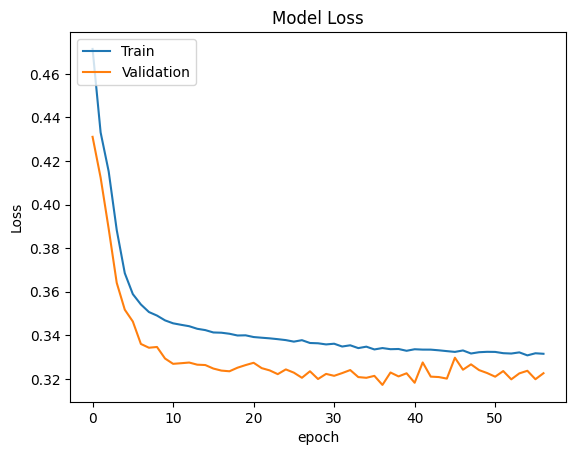

In [60]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [62]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred >= 0.5)

63/63 [==============================] - 0s 2ms/step


In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[1527,   68],
       [ 205,  200]])

In [65]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred,y_test)
score

0.8635

In [66]:
## Get the weights of neural network
classifier.get_weights()

[array([[ 1.88500345e-01, -1.92272961e-01, -2.22082641e-02,
          4.18682396e-01,  6.39667138e-02, -1.26973346e-01,
         -1.97123259e-01,  3.83963324e-02,  6.63629025e-02,
          3.32869053e-01,  1.56115353e-01],
        [-1.74613744e-02, -5.94374835e-01, -4.72645849e-01,
         -1.32462293e-01, -1.75459266e-01, -6.79033995e-01,
         -7.45492637e-01,  8.48782599e-01,  1.35241419e-01,
         -8.14807057e-01, -7.35143244e-01],
        [ 2.16648132e-01,  3.03596884e-01,  1.08777285e-01,
         -4.98365998e-01, -1.00360915e-01,  3.58418067e-04,
         -3.50078009e-02, -2.43923496e-02, -2.43768781e-01,
         -1.63347363e-01, -1.36973709e-01],
        [ 2.64283735e-02, -1.50551155e-01,  1.37651443e-01,
         -4.45057154e-01,  4.21821952e-01,  1.51819289e-01,
         -3.80057633e-01, -3.76171842e-02, -3.75664473e-01,
          2.44469255e-01,  6.08384982e-02],
        [ 2.66911924e-01,  2.04931125e-01,  1.19129375e-01,
          1.79452255e-01,  1.11945844e+00,  